In [1]:
# Data reading
# ==============================================================================
import numpy as np
import pandas as pd
import xarray as xr
import glob

# Graphics 
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Preprocessing and modeling
# ==============================================================================
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
from sklearn.metrics import mean_absolute_percentage_error
# Warnings configuration 
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Read your data
data = xr.open_dataset(path+'DATASET_ERA5.nc')
data_copy = data

In [6]:
hzn = 24
Y1 = data_copy.mn2t[hzn:]
X1 = data_copy#.drop(['mn2t'])
X1 = X1.sel(time=data_copy.time[:-hzn]) 
scaler = StandardScaler()

In [6]:
def prepro(X, Y, i, j, t_sz):
    lat = X.latitude[i]
    lon = X.longitude[j]
    
    x_sub = X.sel(latitude = lat, longitude = lon)
    x_sub = x_sub.to_array()
    # - Swapaxes to have a array with shape (n_samples, n_features)
    x_sub = np.swapaxes(x_sub, 0,1)
    y_sub = Y.sel(latitude = lat, longitude = lon).values
    # - Standarization of the data
    x_sub_s = scaler.fit_transform(x_sub)
    y_sub_s = scaler.fit_transform(y_sub.reshape(-1,1))
    y_sub_s = y_sub_s.reshape(y_sub.shape)
            
    #==================== Split the data ==================== 
    # - In this case we avoid use shuffle because the data order is important
    x_train, x_test, y_train, y_test = train_test_split(
        x_sub_s, y_sub_s, test_size=t_sz, shuffle = False)
    
    return x_train, x_test, y_train, y_test

# Build a function to integrate space by a choosen statistic 
def dt_to_df(dt, stat):
    if stat=='mean':
        stat_arr = np.nanmean(dt, axis=(1,2))
    elif stat=='median':
        stat_arr = np.nanmedian(dt, axis=(1,2))
    elif stat=='min':
        stat_arr = np.nanmin(dt, axis=(1,2))
    elif stat=='sum':
        stat_arr = np.sum(dt, axis=(1,2))
    else:
        print('stat no valid')
        
    df = pd.DataFrame(stat_arr.transpose())
    
    return df



In [16]:
# - Model instantiation
lmr = linear_model.Ridge(fit_intercept=False)

In [7]:
X_3d = X1.to_array()
# - Swapaxes to have a array with shape (n_samples, n_features)
X_3d = np.swapaxes(X_3d, 0,1)
Y_3d = Y1.values

# - Reshaping to one dimension
X_1d = np.nanmean(X_3d,axis=(2,3))
Y_1d = np.nanmean(Y_3d,axis=(1,2))
# - Standarization of the data
x_s = scaler.fit_transform(X_1d)
y_s = scaler.fit_transform(Y_1d.reshape(-1,1))
y_s = y_s.reshape(Y_1d.shape)

In [8]:
#==================== Split the data ==================== 
# - In this case we avoid use shuffle because the data order is important
x_train, x_test, y_train, y_test = train_test_split(
    x_s, y_s, test_size=0.33, shuffle = False)

In [212]:
lmr.fit(x_train,y_train)

Ridge(fit_intercept=False)

In [213]:
lmr.coef_

array([ 0.02275401, -0.01955008,  0.905688  , -0.0434726 ,  0.03950069,
       -0.01318092], dtype=float32)

In [214]:
# - Arrays to save models metrics
n_met = 3
lats = data.latitude.shape[0]
lons = data.longitude.shape[0]
val_met = np.zeros((n_met, lats, lons))*np.nan

In [215]:
for i in range(Y1.shape[1]):
    for j in range(Y1.shape[2]):
        # - With this condition, the zones masked in previous steps are discarded.
        if (np.isnan(Y1[:,i,j]).sum())<10:
            #==================== Pre-Processing ==================== 
            x_tr, x_tst, y_tr, y_tst = prepro(X1, Y1, i, j, 0.33)

            #======================================================
            #              Aplication of the models
            #======================================================
            #==================== Linear Model ====================
        
            y_prd1d = lmr.predict(x_tst)
            
            lmr_score = lmr.score(x_tr, y_tr)
            val_met[0,i,j] = lmr_score
            lmr_r2 = r2_score(y_tst, y_prd1d)
            val_met[1,i,j] = lmr_r2
            lmr_mape = mean_absolute_percentage_error(y_tst, y_prd1d)
            val_met[2,i,j] = lmr_mape           

In [216]:
y_pred = lmr.predict(x_test)

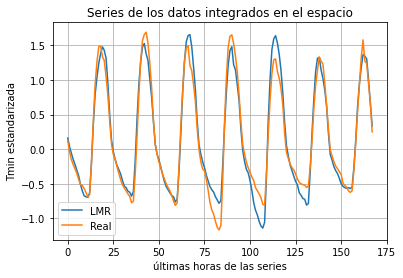

In [217]:
plt.plot(y_pred[-168:], label='LMR')
plt.plot(y_test[-168:], label='Real')
plt.legend()
plt.xlabel('últimas horas de las series')
plt.ylabel('Tmin estandarizada')
plt.grid(':')
plt.title('Series de los datos integrados en el espacio')
plt.savefig(save_imgs+'LMR_series_zona.png', dpi=300)

In [36]:
bar = [0.92, 0.2, 0.02, 0.6]

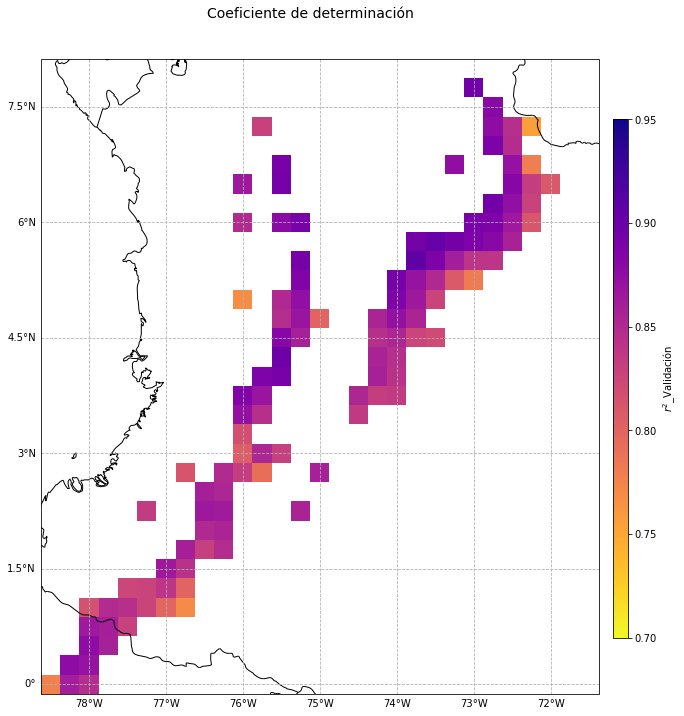

In [225]:
fig,ax = plt.subplots(figsize=(10,12),
                      subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.pcolormesh(data.longitude,data.latitude, val_met[1],cmap='plasma_r', vmin=0.7, vmax=0.95)
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
Y.latitude.shape[0]
cax = fig.add_axes(bar)
cbar = fig.colorbar(im,cax=cax)
cbar.set_label('$r^2$_Validación')
fig.suptitle('Coeficiente de determinación',y=0.93,fontsize=14)
plt.savefig(save_imgs+'LMR_r2_map.png', dpi=300)

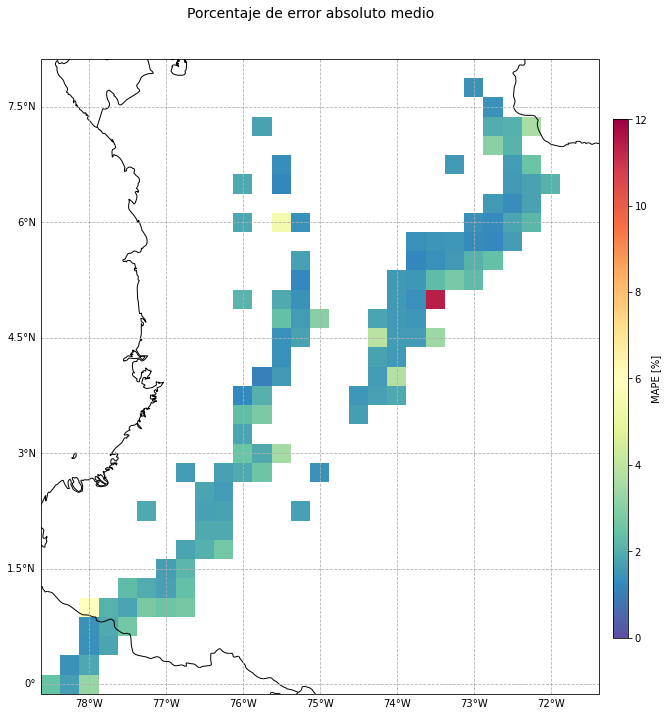

In [226]:
fig,ax = plt.subplots(figsize=(10,12),
                      subplot_kw={'projection': ccrs.PlateCarree()})

im = ax.pcolormesh(data.longitude,data.latitude, val_met[2], cmap='Spectral_r', vmin=0, vmax=12)
gl = ax.gridlines(draw_labels=True,linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
Y.latitude.shape[0]
cax = fig.add_axes(bar)
cbar = fig.colorbar(im,cax=cax)
cbar.set_label('MAPE [%]')
fig.suptitle('Porcentaje de error absoluto medio',y=0.93,fontsize=14)
plt.savefig(save_imgs+'LMR_MAPE_map.png', dpi=300)

In [17]:
n_data, train_sc, test_sc = learning_curve(lmr, x_train, y_train, train_sizes = np.linspace(0.0001, 0.05, 30))

In [18]:
train_sc = np.min(train_sc, axis=1)
test_sc = np.min(test_sc, axis=1)

Text(0, 0.5, 'Score')

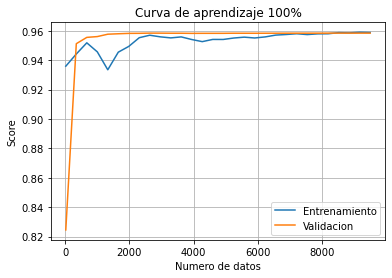

In [19]:
plt.plot(n_data, train_sc, label='Entrenamiento')
plt.plot(n_data, test_sc, label='Validacion')
plt.grid(':')
plt.legend()
plt.title('Curva de aprendizaje 100%')
plt.xlabel('Numero de datos')
plt.ylabel('Score')
#plt.savefig(save_imgs+'LMR_LC100.png', dpi=300)